## Figure 4: Calibration of nonequilibrium switching time required to achieve good precision for nonequilibrium estimates

In [1]:
import numpy as np
import mdtraj as md
import os

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

In [165]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes\n",
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title\n",
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels\n",
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\n",
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\n",
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize\n",
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title"

default_color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(default_color_cycle)

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


left: forward neq work distributions as a function of switching for both complex and solvent 
right: stddev of the forward work distribution as a function of switching time and stat error in free enregy corrections

Note: the work distribution of different annealing (0, 500 steps) times for lig0 are saved to `out_old_works.npz` whereas 5000 (production) is saved in the aggregated dictionary.

In [3]:
lig0_works = np.load('out_old_works.npz', allow_pickle=True)['arr_0'].item()


In [4]:
lig0_works_complex = lig0_works['complex']['old']
lig0_works_solvent = lig0_works['solvent']['old']

In [92]:
all_aggregated_works = np.load('aggregation_dictionaries.npz', allow_pickle=True)['forward'].item()

In [93]:
lig0_works_complex_5000 = all_aggregated_works[0]['complex'][0]
lig0_works_solvent_5000 = all_aggregated_works[0]['solvent'][0]

I have to pull the BAR computed free energy...

In [94]:
free_energies = np.load(f"ANI2_ligand_dg_corrections.kT.npz", allow_pickle=True)['arr_0'].item()

In [95]:
complex_dg, complex_ddg = free_energies[0]['complex']
solvent_dg, solvent_ddg = free_energies[0]['solvent']

In [96]:
complex_1_step = np.array([val[-1] for val in lig0_works_complex[1]])

In [97]:
def subsample_free_energies(distribution, num_subsamples=1000):
    from pymbar.exp import EXP
    stddevs = []
    for i in range(num_subsamples):
        inter_vals = np.random.choice(distribution, 100)
        stddev = np.std(inter_vals)
        stddevs.append(stddev)
        
    
    return np.array(stddevs)
        

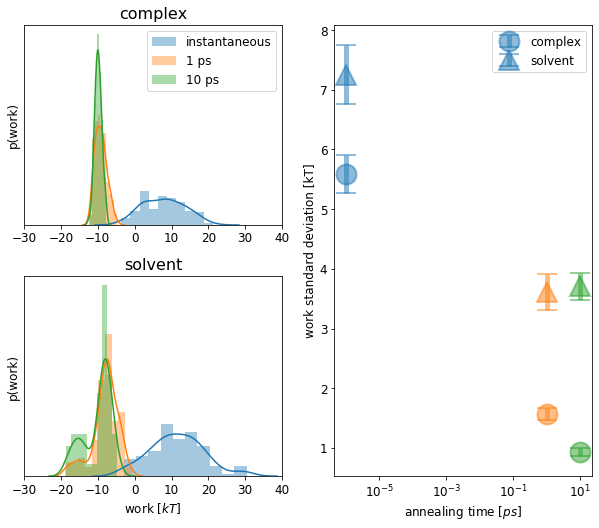

In [168]:
fig = plt.figure(figsize=(8.5, 7.5))
nbins=10

complex_1_step = np.array([val[-1] for val in lig0_works_complex[1]])
complex_500_step = np.array([val[-1] for val in lig0_works_complex[500]])

solvent_1_step = np.array([val[-1] for val in lig0_works_solvent[1]])
solvent_500_step = np.array([val[-1] for val in lig0_works_solvent[500]])

from pymbar.exp import EXP
complex_EXPs = [EXP(complex_1_step)[0], EXP(complex_500_step)[0], EXP(lig0_works_complex_5000)[0]]
solvent_EXPs = [EXP(solvent_1_step)[0], EXP(solvent_500_step)[0], EXP(lig0_works_solvent_5000)[0]]

comp_dg = complex_EXPs[0]

xlims = [-30, 40]


ax3 = fig.add_subplot(1, 2, 2)
annealing_times = [0, 1, 10]
mod_annealing_times = np.array(annealing_times) + 1e-6
from pymbar.exp import EXP

complex_stddevs = [np.std(complex_1_step), np.std(complex_500_step), np.std(lig0_works_complex_5000)]
solvent_stddevs = [np.std(solvent_1_step), np.std(solvent_500_step), np.std(lig0_works_solvent_5000)]

resampled_complex = [np.std(subsample_free_energies(complex_1_step)), np.std(subsample_free_energies(complex_500_step)), np.std(subsample_free_energies(lig0_works_complex_5000))]
resampled_solvent = [np.std(subsample_free_energies(solvent_1_step)), np.std(subsample_free_energies(solvent_500_step)), np.std(subsample_free_energies(lig0_works_solvent_5000))]

for idx in range(3):
    if idx==0:
        complex_label = 'complex'
        solvent_label = 'solvent'
    else:
        complex_label, solvent_label=None, None
    ax3.errorbar(mod_annealing_times[idx], complex_stddevs[idx], ls='None', yerr = resampled_complex[idx], label = complex_label, ms = 20, marker='o', color = default_color_cycle[idx], alpha=0.5, elinewidth=5, capsize=10, markeredgewidth=2)
    ax3.errorbar(mod_annealing_times[idx], solvent_stddevs[idx], ls='None', yerr = resampled_solvent[idx], label = solvent_label, ms = 20, marker='^', color = default_color_cycle[idx], alpha=0.5, elinewidth=5, capsize=10, markeredgewidth=2)
ax3.set_xlabel(f"annealing time [$ps$]")
ax3.set_ylabel(f"work standard deviation [kT]")
# ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.legend()

ax0 = fig.add_subplot(2, 2, 1)
sns.distplot(complex_1_step - comp_dg, ax=ax0, label = 'instantaneous', bins=nbins)
sns.distplot(complex_500_step - comp_dg, ax=ax0, label = '1 ps', bins=nbins)
sns.distplot(lig0_works_complex_5000 - comp_dg, ax=ax0, label= '10 ps', bins=nbins)
#ax0.set_xlabel("work [$kT$]")
ax0.set_ylabel(f"p(work)")
#ax0.set_xlim(-80 - 1.8682e6, -20 - 1.8682e6)
ax0.set_title(f"complex")
ax0.set_xlim(xlims)
ax0.set_yticks([])
ax0.legend()

ax1 = fig.add_subplot(2, 2, 3)

sns.distplot(solvent_1_step - comp_dg, ax=ax1, label = 'instantaneous', bins=nbins)
sns.distplot(solvent_500_step - comp_dg, ax=ax1, label = '1 ps', bins=nbins)
sns.distplot(lig0_works_solvent_5000 - comp_dg, ax=ax1, label = '10 ps', bins=nbins)
ax1.set_xlabel("work [$kT$]")
ax1.set_ylabel(f"p(work)")
#ax1.set_xlim(-80 - 1.8682e6, -20 - 1.8682e6)
ax1.set_title(f"solvent")
ax1.set_xlim(xlims)
ax1.set_yticks([])
#ax1.legend()



# ax3 = fig.add_subplot(1, 2, 2)
# annealing_times = [0, 1, 10]
# from pymbar.exp import EXP
# complex_EXPs = [EXP(complex_1_step)[0], EXP(complex_500_step)[0], EXP(lig0_works_complex_5000)[0]]
# solvent_EXPs = [EXP(solvent_1_step)[0], EXP(solvent_500_step)[0], EXP(lig0_works_solvent_5000)[0]]
# complex_stddevs = [np.std(complex_1_step), np.std(complex_500_step), np.std(lig0_works_complex_5000)]
# solvent_stddevs = [np.std(solvent_1_step), np.std(solvent_500_step), np.std(lig0_works_complex_5000)]
# ax3.plot(annealing_times, complex_stddevs, lw = 3, label = f"complex")
# ax3.plot(annealing_times, solvent_stddevs, lw = 3, label = f"solvent")
# ax3.set_xlabel(f"annealing time [$ps$]")
# ax3.set_ylabel(f"EXP error [kT]")
# ax3.legend()



plt.tight_layout()
plt.savefig(f"Fig4.pdf")

I am subsampling the EXP errors, so the curve is stochastic

lets plot forward/backward works for `all_aggregated_works`...

In [100]:
forward_aggregated_works = np.load('aggregation_dictionaries.npz', allow_pickle=True)['forward'].item()
backward_aggregated_works = np.load('aggregation_dictionaries.npz', allow_pickle=True)['backward'].item()

In [111]:
forward_0_complex = np.concatenate(forward_aggregated_works[0]['complex'])
backward_0_complex = np.concatenate(backward_aggregated_works[0]['complex'])
forward_0_solvent = np.concatenate(forward_aggregated_works[0]['solvent'])
backward_0_solvent = np.concatenate(backward_aggregated_works[0]['solvent'])

In [112]:
forward_13_complex = np.concatenate(forward_aggregated_works[13]['complex'])
backward_13_complex = np.concatenate(backward_aggregated_works[13]['complex'])
forward_13_solvent = np.concatenate(forward_aggregated_works[13]['solvent'])
backward_13_solvent = np.concatenate(backward_aggregated_works[13]['solvent'])

In [115]:
#compute free energies
from pymbar.bar import BAR
BAR_0_complex = BAR(forward_0_complex, backward_0_complex)
BAR_0_solvent = BAR(forward_0_solvent, backward_0_solvent)
BAR_13_complex = BAR(forward_13_complex, backward_13_complex)
BAR_13_solvent = BAR(forward_13_solvent, backward_13_solvent)

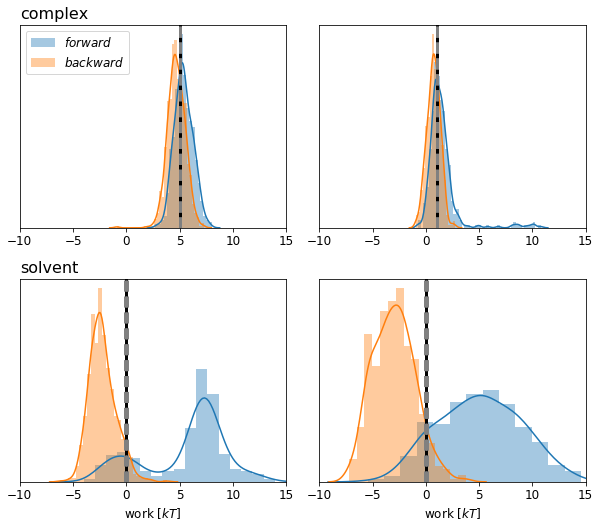

In [169]:
fig = plt.figure(figsize=(8.5, 7.5))

ax0 = fig.add_subplot(2, 2, 1)
ax0.set_title("complex", loc='left')
sns.distplot(forward_0_complex - BAR_0_solvent[0], ax=ax0, label = "$forward$")
sns.distplot(-backward_0_complex - BAR_0_solvent[0], ax=ax0, label = "$backward$")
ax0.axvline(BAR_0_complex[0] - BAR_0_solvent[0], color='k', lw=3)
ax0.axvline(BAR_0_complex[0] - BAR_0_solvent[0] + BAR_0_complex[1], color='gray', lw=3, ls='--')
ax0.axvline(BAR_0_complex[0] - BAR_0_solvent[0] - BAR_0_complex[1], color='gray', lw=3, ls='--')
ax0.set_yticks([])
ax0.set_xlim(-10, 15)
ax0.legend(loc = 'upper left')

ax1 = fig.add_subplot(2,2,3)
ax1.set_title("solvent", loc='left')
sns.distplot(forward_0_solvent - BAR_0_solvent[0], ax=ax1)
sns.distplot(-backward_0_solvent - BAR_0_solvent[0], ax=ax1)
ax1.set_yticks([])
ax1.axvline(BAR_0_solvent[0] - BAR_0_solvent[0], color='k', lw=3)
ax1.axvline(BAR_0_solvent[0] - BAR_0_solvent[0] + BAR_0_solvent[1], color='gray', lw=3, ls='--')
ax1.axvline(BAR_0_solvent[0] - BAR_0_solvent[0] - BAR_0_solvent[1], color='gray', lw=3, ls='--')
ax1.set_xlim(-10, 15)
ax1.set_xlabel(f"work [$kT$]")


ax2 = fig.add_subplot(2, 2, 2)
#ax2.set_title("complex", loc='left')
sns.distplot(forward_13_complex - BAR_13_solvent[0], ax=ax2, label = "$forward$")
sns.distplot(-backward_13_complex - BAR_13_solvent[0], ax=ax2, label = "$backward$")
ax2.axvline(BAR_13_complex[0] - BAR_13_solvent[0], color='k', lw=3)
ax2.axvline(BAR_13_complex[0] - BAR_13_solvent[0] + BAR_13_complex[1], color='gray', lw=3, ls='--')
ax2.axvline(BAR_13_complex[0] - BAR_13_solvent[0] - BAR_13_complex[1], color='gray', lw=3, ls='--')
ax2.set_yticks([])
ax2.set_xlim(-10, 15)
#ax2.legend(loc = 'upper left')

ax3 = fig.add_subplot(2,2,4)
#ax3.set_title("solvent", loc='left')
sns.distplot(forward_13_solvent - BAR_13_solvent[0], ax=ax3)
sns.distplot(-backward_13_solvent - BAR_13_solvent[0], ax=ax3)
ax3.set_yticks([])
ax3.axvline(BAR_13_solvent[0] - BAR_13_solvent[0], color='k', lw=3)
ax3.axvline(BAR_13_solvent[0] - BAR_13_solvent[0] + BAR_13_solvent[1], color='gray', lw=3, ls='--')
ax3.axvline(BAR_13_solvent[0] - BAR_13_solvent[0] - BAR_13_solvent[1], color='gray', lw=3, ls='--')
ax3.set_xlim(-10, 15)
ax3.set_xlabel(f"work [$kT$]")

plt.tight_layout()
plt.savefig(f"Fig5.pdf")